## Librairies 

In [48]:
import numpy as np
import mpctools as mpc
import mpctools.plots as mpcplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import control as ctrl
import optuna
import time

## State-space representation

In [49]:
# Longitudinal flight dynamics 
# Acont = [udot, wdot, qdot, thetadot, hdot]'
Acont = np.array([[-0.026, 0.074, -0.804, -9.809,0],
              [-0.242, -2.017, 73.297, -0.105, -0.001],
              [0.003, -0.135, -2.941, 0, 0],
              [0,       0,      1,    0,0],
              [-0.011, 1,        0 ,   -75, 0]])

# Bcont = [delta_th,delta_e]
Bcont = np.array([[4.594,0], [-0.0004, -13.735], [0.0002,-24.410], [0,0],[0,0]]) 

# Ccont = measured states theta and h
Ccont = np.array([[0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

Dcont = np.array([[0], [0]])

## Controllability and observability

In [50]:
def pbh_controllability(A, B):
    n = A.shape[0]
    eigenvalues = np.linalg.eigvals(A)

    for i in eigenvalues:
        rank_test = np.linalg.matrix_rank(np.hstack([A - i * np.eye(n), B]))
        if rank_test < n:
            print(f"System is NOT controllable. Uncontrollable mode at lambda = {i:.4f}")
            return False

    print("System is controllable.")
    return True

def pbh_observability(A, C):
    n = A.shape[0]
    eigenvalues = np.linalg.eigvals(A)

    for j in eigenvalues:
        rank_test = np.linalg.matrix_rank(np.vstack([j * np.eye(n) - A, C]))
        if rank_test < n:
            print(f"System is NOT observable. Unobservable mode at lambda = {j:.4f}")
            return False

    print("System is observable.")
    return True

# Check controllability and observability
pbh_controllability(Acont, Bcont)
pbh_observability(Acont, Ccont)

System is controllable.
System is observable.


True

## MPC design

In [ ]:
n = Acont.shape[0] # Number of states.
m = Bcont.shape[1] # Number of control elements

# Discretize.
dt = 0.25
Nt = 20 # Pas de temps
(A, B) = mpc.util.c2d(Acont,Bcont,dt)

def ffunc(x,u):
    """Linear discrete-time model."""
    return mpc.mtimes(A, x) + mpc.mtimes(B, u)
f = mpc.getCasadiFunc(ffunc, [n, m], ["x", "u"], "f")

umax = [1, 0.262]  # [Throttle, Elevator]
umin = [0, -0.262]
dumax = [0.1, 0.524]  # Rate constraints
dumin = [-0.1, -0.524]

# State constraints
theta_max = 0.349  
theta_min = -0.349

x_min = [-np.inf, -np.inf, -np.inf, theta_min, -np.inf]  
x_max = [np.inf, np.inf, np.inf, theta_max, np.inf]

# Set constraints in MPC
lb = dict(u=umin, du=dumin, x=x_min)
ub = dict(u=umax, du=dumax, x=x_max)

# Define Q and R matrices.
Q = np.diag([1, 1/0.12, 1/0.012, 1/0.12, 1/0.0172])
R = np.diag([1/0.52, 1/0.17452])

def lfunc(x,u):
    """Quadratic stage cost."""
    return mpc.mtimes(x.T, Q, x) + mpc.mtimes(u.T, R, u)

l = mpc.getCasadiFunc(lfunc, [n,m], ["x","u"], "l")

# Initial condition and sizes.
x0 = np.array([15, 0, 0, 0, 100])  # [u, w, q, θ, h]
N = {"x" : n, "u" : m, "t" : Nt}


## Solving MPC

In [52]:
# Solve MPC
solver = mpc.nmpc(f, l, N, x0, lb, ub,verbosity=0, isQP=True)
nsim = 40
t = np.arange(nsim + 1) * dt
xcl = np.zeros((n, nsim + 1))
xcl[:, 0] = x0
ucl = np.zeros((m, nsim))
ducl = np.zeros((m, nsim))
x4cl = np.zeros(nsim + 1)
for k in range(nsim):
    solver.fixvar("x", 0, x0)
    sol = mpc.callSolver(solver)
    print("Iteration %d Status: %s" % (k, sol["status"]))
    xcl[:, k] = x0
    x4cl[k] = x0[3]  
    ucl[:, k] = sol["u"][0, :]    
    if k > 0:
        ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
    else:
        ducl[:, k] = ucl[:, k] - 0
    x0 = ffunc(x0, ucl[:, k])
xcl[:, nsim] = x0
x4cl[nsim] = x0[3]



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Iteration 0 Status: Successful return.
I

## Closed-loop response

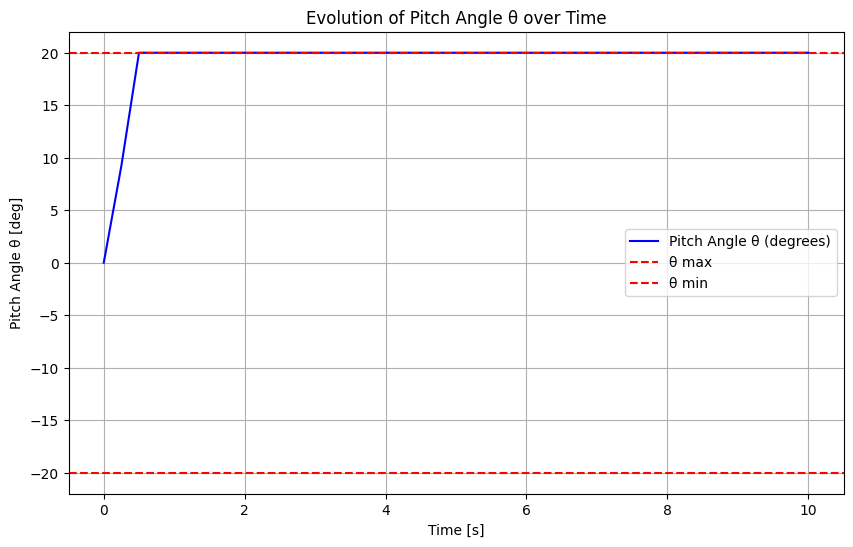

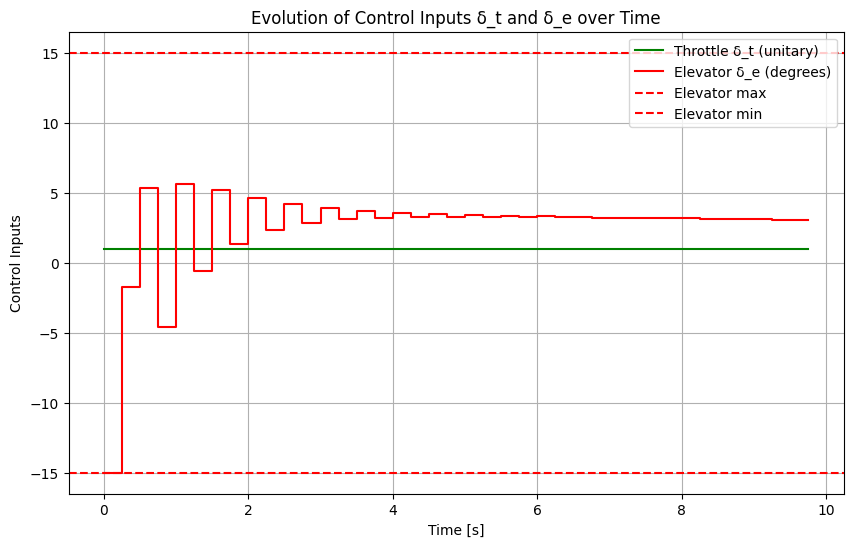

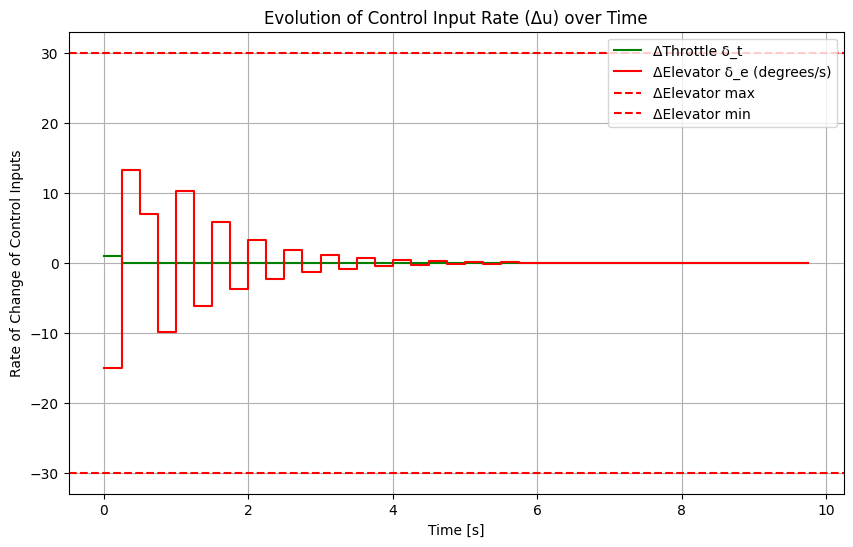

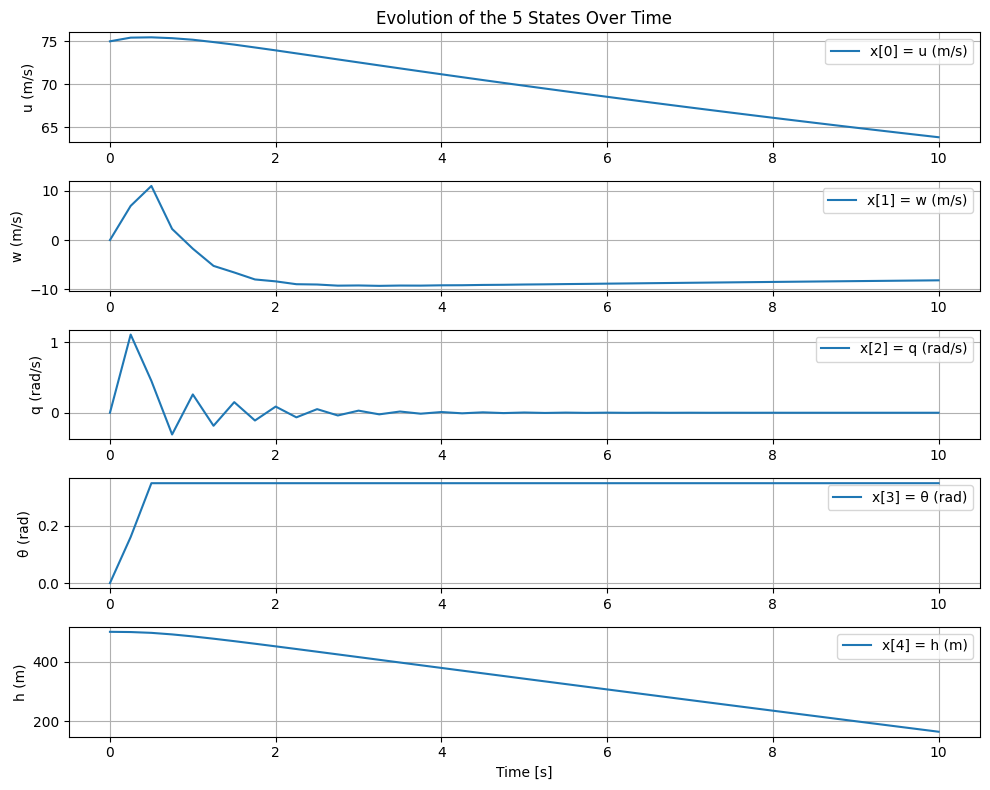

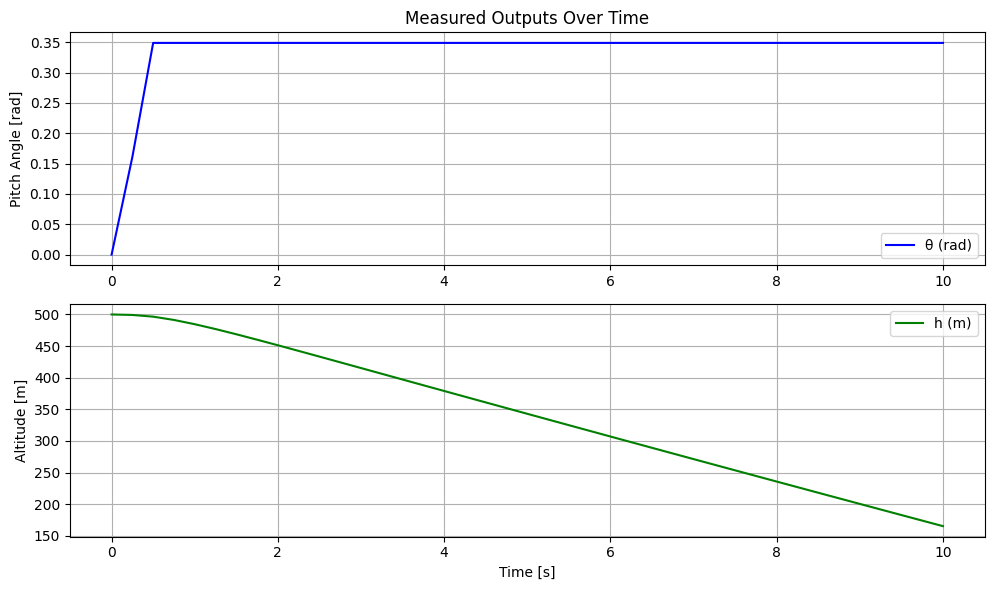

In [ ]:
# Convert x4 from radians to degrees
x4_degrees = np.degrees(xcl[3, :])  
theta_max_degrees = np.degrees(theta_max)  
theta_min_degrees = np.degrees(theta_min)

# Plot x4 
plt.figure(figsize=(10, 6))
plt.plot(t, x4_degrees, label='Pitch Angle θ (degrees)', color='b')
plt.axhline(theta_max_degrees, color='r', linestyle='--', label='θ max')
plt.axhline(theta_min_degrees, color='r', linestyle='--', label='θ min')
plt.xlabel('Time [s]')
plt.ylabel('Pitch Angle θ [deg]')
plt.title('Evolution of Pitch Angle θ over Time')
plt.legend()
plt.grid()
plt.show()

# Convert control inputs
umax_degrees = [umax[0], np.degrees(umax[1])]  
umin_degrees = [umin[0], np.degrees(umin[1])]
ucl_degrees = np.copy(ucl)
ucl_degrees[1, :] = np.degrees(ucl[1, :])  

# Plot throttle and elevator 
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ucl_degrees[0, :], where='post', label='Throttle δ_t (unitary)', color='g')
plt.step(t[:-1], ucl_degrees[1, :], where='post', label='Elevator δ_e (degrees)', color='r')
plt.axhline(umax_degrees[1], color='r', linestyle='--', label='Elevator max')
plt.axhline(umin_degrees[1], color='r', linestyle='--', label='Elevator min')
plt.xlabel('Time [s]')
plt.ylabel('Control Inputs')
plt.title('Evolution of Control Inputs δ_t and δ_e over Time')
plt.legend()
plt.grid()
plt.show()

# Convert rate of change of control inputs
ducl_degrees = np.copy(ducl)
ducl_degrees[1, :] = np.degrees(ducl[1, :])  

dumax_degrees = [dumax[0], np.degrees(dumax[1])]
dumin_degrees = [dumin[0], np.degrees(dumin[1])]

# Plot control rate
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ducl_degrees[0, :], where='post', label='ΔThrottle δ_t', color='g')
plt.step(t[:-1], ducl_degrees[1, :], where='post', label='ΔElevator δ_e (degrees/s)', color='r')
plt.axhline(dumax_degrees[1], color='r', linestyle='--', label='ΔElevator max')
plt.axhline(dumin_degrees[1], color='r', linestyle='--', label='ΔElevator min')
plt.xlabel('Time [s]')
plt.ylabel('Rate of Change of Control Inputs')
plt.title('Evolution of Control Input Rate (Δu) over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))

state_labels = ["u (m/s)", "w (m/s)", "q (rad/s)", "θ (rad)", "h (m)"]
for i in range(n):  # n=5
    plt.subplot(n, 1, i+1)
    plt.plot(t, xcl[i, :], label=f"x[{i}] = {state_labels[i]}")
    plt.ylabel(state_labels[i])
    plt.grid(True)
    if i == 0:
        plt.title("Evolution of the 5 States Over Time")
    if i == n-1:
        plt.xlabel("Time [s]")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Compute the measured outputs y for each time step
ycl = np.zeros((Ccont.shape[0], nsim+1))  # shape: (2, nsim+1)

for k in range(nsim+1):
    # y = C*x
    ycl[:, k] = Ccont @ xcl[:, k]  # (2,)

# Plot the measured outputs
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, ycl[0, :], label="θ (rad)", color="b")
plt.ylabel("Pitch Angle [rad]")
plt.title("Measured Outputs Over Time")
plt.grid(True)
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(t, ycl[1, :], label="h (m)", color="g")
plt.xlabel("Time [s]")
plt.ylabel("Altitude [m]")
plt.grid(True)
plt.legend(loc="best")

plt.tight_layout()
plt.show()

